# Vector Autoregression Model

This notebook is generalized code to run a Vector Autoregression Model on the cleaned Zillow Home Value Index dataset created in a different notebook.

In [2]:
location = "SaltLakeCityUT" #USER INPUT -- In overall genearlized notebook.

/var/folders/j2/lf9zt3017c3fz8rrnty2f8h80000gn/T/ipykernel_57195/3788878552.py:34: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, column_data in market_df.iteritems():
/var/folders/j2/lf9zt3017c3fz8rrnty2f8h80000gn/T/ipykernel_57195/3788878552.py:47: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, column_data in df_differenced.iteritems():


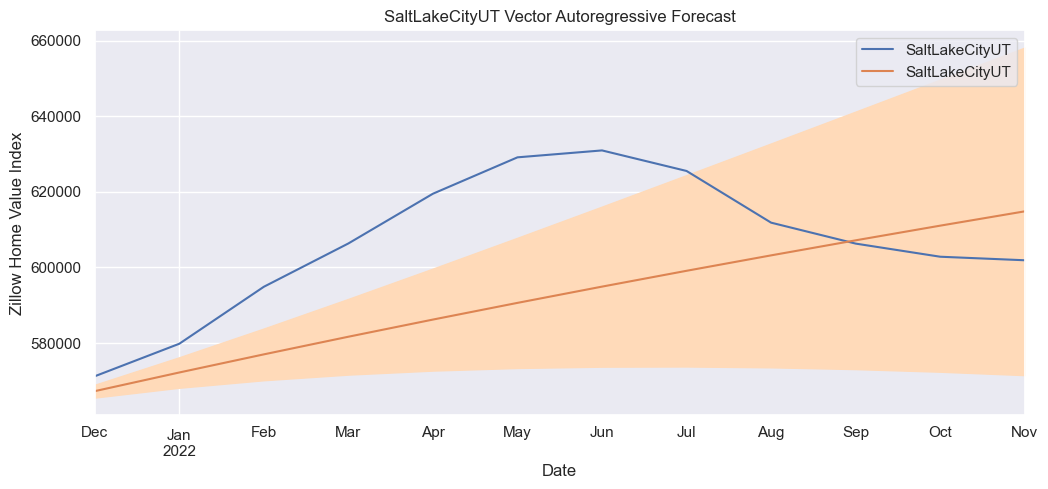

The Mean Absolute Percentage Error (MAPE) for the Zillow Home Value Index Vector Autoregression Forecast is 2.97%.


In [3]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style = "darkgrid")

###############################################################################################

#Set up dataframe
market_area_city = location[:-2]
full_df = pd.read_pickle('data/fulldataframe.pkl')
full_df.set_index('date', inplace = True)
full_df.index.freq = 'm'
market_specific_features = [col for col in full_df.columns if market_area_city in col]
market_df = full_df[market_specific_features + ['MORTGAGE30US', 'MedianCPI', 'HomesForSale', 'HomesSold']].copy()

###############################################################################################

#Import Statsmodels Libraries

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic, bic
from statsmodels.tsa.stattools import adfuller

###############################################################################################

#Check for Stationarity with Augmented Dickey-Fuller Test  
p_values_n1 = np.array([])
n = 0

for column_name, column_data in market_df.iteritems():
    
    #first adf_test
    adf_test = adfuller(column_data, autolag = 'BIC')
    p_values_n1 = np.append(p_values_n1, adf_test[1])
    
#check p_values for first difference
if np.any(p_values_n1 > 0.05):
    df_differenced = market_df.diff().dropna()
    n = 1
    
p_values_n2 = np.array([])

for column_name, column_data in df_differenced.iteritems():
    
    #second adf_test
    adf_test = adfuller(column_data, autolag = 'BIC')
    p_values_n2 = np.append(p_values_n2, adf_test[1])

#check p_values for second difference
if np.any(p_values_n2 > 0.05) and (np.sum(p_values_n1 > 0.05) > np.sum(p_values_n2 > 0.05)):
    df_differenced = df_differenced.diff().dropna()
    n = 2     

###############################################################################################        
        
#Split the data into Train and Test

test_obs = 12
train_df = df_differenced[:-test_obs]
test_df = df_differenced[-test_obs:]

############################################################################################### 

#Select the order p by minimizing BIC

model = VAR(train_df)
lag_order = model.select_order(maxlags = 12)
p = lag_order.bic

###############################################################################################

#Fit the model on order p

result = model.fit(p)

###############################################################################################

#Use the last lagged values of order p from train_df to forecast the next test_obs time steps

lagged_values = train_df.values[-p:]

pred = result.forecast(y = lagged_values, steps = test_obs)
pred_lower = result.forecast_interval(y = lagged_values, steps = test_obs)[1]
pred_upper = result.forecast_interval(y = lagged_values, steps = test_obs)[2]

df_forecast = pd.DataFrame(data = pred, index = test_df.index[:test_obs], columns = test_df.columns)
df_forecast_lower = pd.DataFrame(data = pred_lower, index = test_df.index[:test_obs], columns = test_df.columns)
df_forecast_upper = pd.DataFrame(data = pred_upper, index = test_df.index[:test_obs], columns = test_df.columns)

###############################################################################################

#Invert differenced values

if n == 2:
    #if second differenced
    df_forecast = (market_df.iloc[-test_obs-1] - market_df.iloc[-test_obs-2]) + df_forecast.cumsum()
    df_forecast_lower = (market_df.iloc[-test_obs-1] - market_df.iloc[-test_obs-2]) + df_forecast_lower.cumsum()
    df_forecast_upper = (market_df.iloc[-test_obs-1] - market_df.iloc[-test_obs-2]) + df_forecas_uppert.cumsum()
    
if n >= 1: 
    #if first differenced 
    df_forecast = market_df.iloc[-test_obs-1] + df_forecast.cumsum()
    df_forecast_lower = market_df.iloc[-test_obs-1] + df_forecast_lower.cumsum()
    df_forecast_upper = market_df.iloc[-test_obs-1] + df_forecast_upper.cumsum()

###############################################################################################

#Plot forecasts vs. actuals

df_actuals = market_df[-test_obs:]
df_actuals.iloc[:, 0].plot(figsize = (12, 5), legend = True)
df_forecast.iloc[:,0].plot(legend = True)
plt.title(location + " Vector Autoregressive Forecast")
plt.xlabel("Date")
plt.ylabel("Zillow Home Value Index")

plt.fill_between(df_forecast.index, df_forecast_lower.iloc[:,0], df_forecast_upper.iloc[:,0], color='peachpuff')

plt.show()

###############################################################################################

#Summarize forecasts
actual = np.array(df_actuals.iloc[:, 0])
prediction = np.array(df_forecast.iloc[:,0])
MAPE = np.mean(np.abs((actual - prediction) / actual)) * 100

print("The Mean Absolute Percentage Error (MAPE) for the Zillow Home Value Index Vector Autoregression Forecast is "
      + str(round(MAPE, 2)) + "%.")

In [4]:
def time_series_cv(data, test_feature, starting_index, horizon, lags):
    
    final_obs = len(data) - horizon
    abs_per_errs = np.array([])
    
    for t in range(starting_index, final_obs):
        df = data.iloc[0:t]
        
        model = VAR(df)
        
        features_prediction = model.fit(lags).forecast(df.values[-lags:,:], horizon)[-1:,:]
        feature_prediction = features_prediction[:, data.columns==market_specific_features[0]]
        
        feature_actual = data.iloc[t+horizon][test_feature]
        abs_per_errs = np.append(abs_per_errs, 100 * np.abs((feature_actual - feature_prediction) / feature_actual))
        
    MAPE = np.mean(abs_per_errs)
    
    print('MAPE:', MAPE)

In [5]:
time_series_cv(data=train_df, test_feature=market_specific_features[0], starting_index=100, horizon=1, lags=p)

MAPE: 262.09421342769593
